# HW №2.3

Исходные данные - из функции `generate_subsample`

Задача - как и с `precision` написать три версии функции подсчета `Mean Reciprocal Rank` (`naive`, `numba`, `pandas`) и потестить на разных размерах выборки

для всех комбинаций (`users_count`, `top_k`):
*   `users_count` – `[100, 1000, 10000, 100000]`
*    `top_k` – `[10, 50, 100]`

Результат - график:
* Алгоритм – `naive`, `numba`, `pandas`
* Скорость
* `users_count`
* `top_k`

In [2]:
import pandas as pd
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import time

from tqdm.auto import tqdm
from rectools import Columns

In [3]:
np.random.seed(2023)

In [4]:
!wget https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip

--2023-03-31 22:25:15--  https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78795385 (75M) [application/zip]
Saving to: 'kion_train.zip'

kion_train.zip      100%[===================>]  75.14M  6.27MB/s    in 11s     

2023-03-31 22:25:26 (6.65 MB/s) - 'kion_train.zip' saved [78795385/78795385]



In [5]:
!unzip kion_train.zip

Archive:  kion_train.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


In [6]:
interactions = pd.read_csv('kion_train/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [7]:
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

## Функции чтобы сгенерить данные для расчета

In [8]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs   

In [9]:
def mrr_naive(df, users, recs, k):
    mrr = []
    for i, user in enumerate(users):
        sum_rev_rank = 0
        user_target = df[df[:, 0] == user][:, 1]
        for rank, rec in enumerate(recs[i]):
            if rec in user_target:
                sum_rev_rank += 1 / (rank + 1)
        mrr.append(sum_rev_rank / k)
    return sum(mrr) / (len(users))

In [10]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        sum_rev_rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rank in nb.prange(len(recs[i])):
            if recs[i][rank] in user_target:
                sum_rev_rank += 1 / (rank + 1)
        mrr[i] = sum_rev_rank / k
    return mrr.mean()

In [11]:
def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    df_recs['1/rank'] = 1 / df_recs[Columns.Rank]
    mrr = df_recs['1/rank'].sum() / (k * len(users))
    return mrr

## Считаем метрики

In [12]:
top_k = 10
users_count = 1000

In [13]:
df, users, recs = generate_subsample(users_count, top_k)
target = df.values

In [14]:
mrr_naive(df, users, recs, top_k)

0.009475992063492056

In [15]:
mrr_numba(target, users, recs, top_k)

0.009475992063492061

In [16]:
mrr_pandas(df, users, recs, top_k)

0.009475992063492063

Ок, значения MRR в каждом из трех методов одинаковые, теперь посмотрим какой метод справляется быстрее с задачей

## Генерируем данные для разных users_count и k_top
### Используем различные методы для подчета метрики

In [17]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

time_naive = []
time_numba = []
time_pandas = []

for k in tqdm(top_k):
    for user in tqdm(users_count):
        df, users, recs = generate_subsample(user, k)
        target = df.values

        # naive-метода для MRR 
        print(f'MRR for top-{k} and {user} users --- naive')
        start_time = time.time()
        mrr_naive(target, users, recs, k)
        time_naive.append(time.time() - start_time)
 
        #  время numba-метода для MRR
        print(f'MRR for top-{k} and {user} users --- numba')
        start_time = time.time()
        mrr_numba(target, users, recs, k)
        time_numba.append(time.time() - start_time)
 
        # время pandas-метода для MRR
        print(f'MRR for top-{k} and {user} users --- pandas')
        start_time = time.time()
        mrr_pandas(df, users, recs, k)
        time_pandas.append(time.time() - start_time)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

MRR for top-10 and 100 users --- naive
MRR for top-10 and 100 users --- numba
MRR for top-10 and 100 users --- pandas
MRR for top-10 and 1000 users --- naive
MRR for top-10 and 1000 users --- numba
MRR for top-10 and 1000 users --- pandas
MRR for top-10 and 10000 users --- naive
MRR for top-10 and 10000 users --- numba
MRR for top-10 and 10000 users --- pandas
MRR for top-10 and 100000 users --- naive
MRR for top-10 and 100000 users --- numba
MRR for top-10 and 100000 users --- pandas


  0%|          | 0/4 [00:00<?, ?it/s]

MRR for top-50 and 100 users --- naive
MRR for top-50 and 100 users --- numba
MRR for top-50 and 100 users --- pandas
MRR for top-50 and 1000 users --- naive
MRR for top-50 and 1000 users --- numba
MRR for top-50 and 1000 users --- pandas
MRR for top-50 and 10000 users --- naive
MRR for top-50 and 10000 users --- numba
MRR for top-50 and 10000 users --- pandas
MRR for top-50 and 100000 users --- naive
MRR for top-50 and 100000 users --- numba
MRR for top-50 and 100000 users --- pandas


  0%|          | 0/4 [00:00<?, ?it/s]

MRR for top-100 and 100 users --- naive
MRR for top-100 and 100 users --- numba
MRR for top-100 and 100 users --- pandas
MRR for top-100 and 1000 users --- naive
MRR for top-100 and 1000 users --- numba
MRR for top-100 and 1000 users --- pandas
MRR for top-100 and 10000 users --- naive
MRR for top-100 and 10000 users --- numba
MRR for top-100 and 10000 users --- pandas
MRR for top-100 and 100000 users --- naive
MRR for top-100 and 100000 users --- numba
MRR for top-100 and 100000 users --- pandas


In [18]:
time_naive = np.array(time_naive).reshape(3, 4)
time_numba = np.array(time_numba).reshape(3, 4)
time_pandas = np.array(time_pandas).reshape(3, 4)

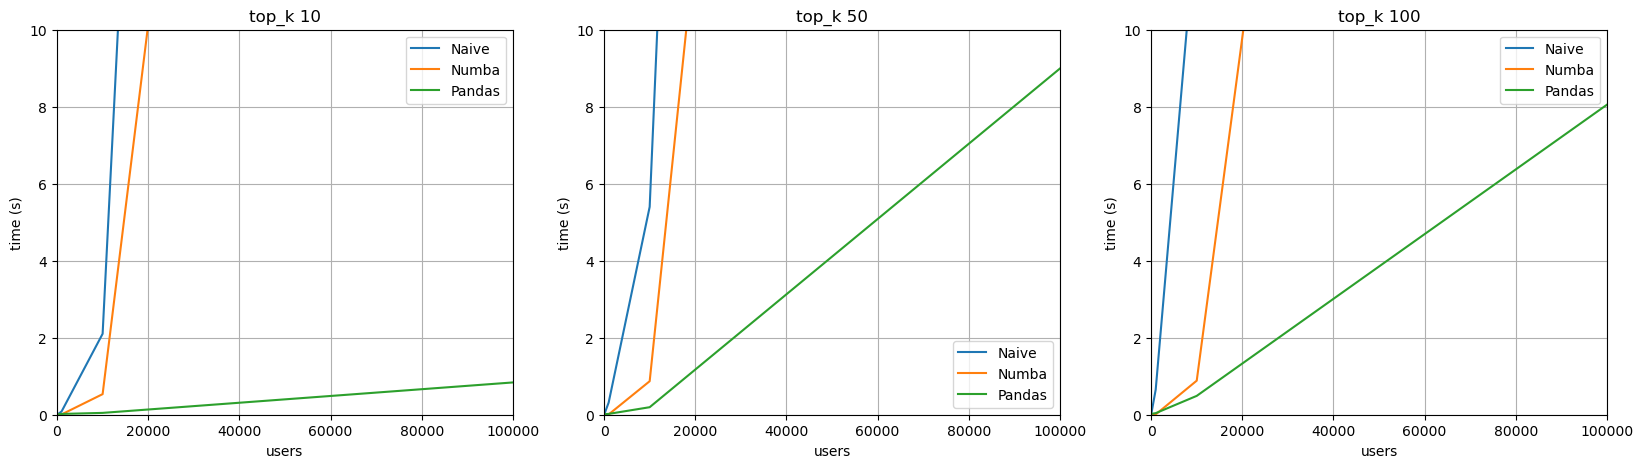

In [19]:
_, ax = plt.subplots(1, 3, figsize=(20,5))
for i in range(3):
    # для каждого k_top и метода - график users–time  
    ax[i].plot(users_count, time_naive[i,:], label='Naive')
    ax[i].plot(users_count, time_numba[i,:], label='Numba')
    ax[i].plot(users_count, time_pandas[i,:], label='Pandas')
    
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_xlabel('users')
    ax[i].set_ylabel('time (s)')
    ax[i].set_xlim(0, 100000)
    ax[i].set_ylim(0, 10)
    ax[i].grid()
    ax[i].legend()
plt.show()

Метод `pandas` работает чуть быстрее других (`naive`, `numba`). Он работает быстрее вообще при любых `k_top` и `users_count`